In [1]:
import warnings
warnings.filterwarnings('ignore')

# 20 Case Study 5 Solution

# 20. 1 Exploring the Data

Let's separately explore the _Profiles_, _Observations_ and _Friendships_ tables.

### 20.1.1 Examining the Profiles
We'll start by loading the _Profiles_ table into Pandas and summarizing the table's contents.

**Listing 23. 1. Loading the Profiles table**

In [2]:
import pandas as pd

def summarize_table(df):
    n_rows, n_columns = df.shape
    summary = df.describe()
    print(f"The table contains {n_rows} rows and {n_columns} columns.")
    print("Table Summary:\n")
    print(summary.to_string())

df_profile = pd.read_csv('friendhook/Profiles.csv')
summarize_table(df_profile)

The table contains 4039 rows and 6 columns.
Table Summary:

          Profile_ID           Sex Relationship_Status          Dorm         Major          Year
count           4039          4039                3631          4039          4039          4039
unique          4039             2                   3            15            30             4
top     6e0b386157c4  e807eb960650        ac0b88e46e20  a8e6e404d1b3  141d4cdd5aaf  c1a648750a4b
freq               1          2020                1963          2739          1366          1796


There is one place in the table summary where the numbers are off; the _Relationship Status_ column. Pandas has detected three _Relationship Status_ categories across 3631 of 4039 table rows. The remaining 400 or so rows are null. They don't contain any assigned relationship status. Lets count the total number of empty rows.

**Listing 23. 2. Counting empty Relationship Status profiles**

In [3]:
is_null = df_profile.Relationship_Status.isnull()
num_null = df_profile[is_null].shape[0]
print(f"{num_null} profiles are missing the Relationship Status field.")

408 profiles are missing the Relationship Status field.


408 profiles do not contain a listed relationship status.  We can treat the lack of status as a fourth _unspecified_ relationship status category. Hence, we should assign these rows a category id. What id value should we choose? Before we answer the question, lets examine all unique ids within the _Relationship Status_ column.

**Listing 23. 3. Checking unique Relationship Status values**

In [4]:
unique_ids = set(df_profile.Relationship_Status.values)
print(unique_ids)

{nan, 'ac0b88e46e20', '9cea719429e9', '188f9a32c360'}


The Scikit-Learn library is unable to process hash-codes or null values. It can only process numbers. Hence, we'll need to eventually convert the categories to numeric values. 

**Listing 23. 4. Mapping Relationship Status values to numbers**

In [5]:
import numpy as np
category_map = {'9cea719429e9': 0, np.nan: 1, '188f9a32c360': 2, 
                'ac0b88e46e20': 3}

Next, we'll replace the contents of the _Relationship Status_ column with the appropriate numeric values.

**Listing 23. 5. Updating the Relationship Status column**

In [6]:
nums = [category_map[hash_code] 
        for hash_code in df_profile.Relationship_Status.values]
df_profile['Relationship_Status'] = nums
print(df_profile.Relationship_Status)

0       0
1       3
2       3
3       3
4       0
       ..
4034    3
4035    0
4036    3
4037    3
4038    0
Name: Relationship_Status, Length: 4039, dtype: int64


We've transformed _Relationship Status_ into a numeric variable. However, the remaining five columns in the table still contain hash-codes. Let's create a category mapping between hash-codes and numbers in each column. We'll track the category mappings in each column with a `col_to_mapping` dictionary. We'll also leverage the mappings in order to replace all hash-codes with numbers in `df_profile`.

**Listing 23. 6. Replacing all Profile hash-codes with numeric values**

In [7]:
col_to_mapping = {'Relationship_Status': category_map}

for column in df_profile.columns:
    if column in col_to_mapping:
        continue
        
    unique_ids = sorted(set(df_profile[column].values))
    category_map = {id_: i for i, id_ in enumerate(unique_ids)}
    col_to_mapping[column] = category_map
    nums = [category_map[hash_code] 
            for hash_code in df_profile[column].values]
    df_profile[column] = nums

head = df_profile.head()
print(head.to_string(index=False))

 Profile_ID  Sex  Relationship_Status  Dorm  Major  Year
       2899    0                    0     5     13     2
       1125    0                    3    12      6     1
       3799    0                    3    12     29     2
       3338    0                    3     4     25     0
       2007    1                    0    12      2     0


We've finished tweaking the `df_profile`. Now lets turn our attention to the table of experimental observations.

### 23.1.2 Exploring the Experimental Observations
We'll start by loading the _Observations_ table into Pandas and summarizing the table's contents.

**Listing 23. 7. Loading the Observations table**

In [9]:
df_obs = pd.read_csv('friendhook/Observations.csv')
summarize_table(df_obs)

The table contains 4039 rows and 5 columns.
Table Summary:

          Profile_ID Selected_Friend Selected_Friend_of_Friend Friend_Request_Sent Friend_Request_Accepted
count           4039            4039                      4039                4039                    4039
unique          4039            2219                      2327                   2                       2
top     6e0b386157c4    89581f99fa1e              6caa597f13cc                True                    True
freq               1              77                        27                2519                    2460


The five table columns all consistantly show 4039 filled rows. There are no empty values in the table. This is good. However, the actual column names are hard to read. The names are very descriptive, but also very long. We should shorten some of the names in order to ease our cognitive load. 

**Listing 23. 8. Renaming the observation columns**

In [10]:
new_names = {'Selected_Friend': 'Friend', 
             'Selected_Friend_of_Friend': 'FoF',
             'Friend_Request_Sent': 'Sent',
             'Friend_Request_Accepted': 'Accepted'}
df_obs = df_obs.rename(columns=new_names)
summarize_table(df_obs)

The table contains 4039 rows and 5 columns.
Table Summary:

          Profile_ID        Friend           FoF  Sent Accepted
count           4039          4039          4039  4039     4039
unique          4039          2219          2327     2        2
top     6e0b386157c4  89581f99fa1e  6caa597f13cc  True     True
freq               1            77            27  2519     2460


Approximately 62% (2519) of the friend suggestions lead to friend request being sent. This is very promising; the friend-of-a-friend suggestions are quite effective. Furthermore, approximately 60% (2460) of sampled instances led to a friend request getting accepted. Hence, the sent friend requests are ignored or rejected just 2% (2519 - 2460 = 50) of the time. Of course, our numbers assume that there are no observations where _Sent_ is False and _Accepted_ is True. This scenario is not possible, because a friend-request cannot be accepted if it has not yet been sent. Still, as sanity check, lets test the integrity of the data by confirm that the scenario does not take place.

**Listing 23. 9. Ensuring that Sent is `True` for all accepted requests**

In [11]:
condition = (df_obs.Sent == False) & (df_obs.Accepted == True)
assert not df_obs[condition].shape[0]

Based on our observations, user behavior follows three possible scenarios. Hence, we can encode this categorical behavior by assigning numbers `0`, `1`, and `2` to the behavior patterns.

**Listing 23. 10. Assigning classes of behavior to the user observations**

In [12]:
behaviors = []
for sent, accepted in df_obs[['Sent', 'Accepted']].values:
    behavior = 2 if (sent and not accepted) else int(sent) * int(accepted)
    behaviors.append(behavior)
df_obs['Behavior'] = behaviors

Additionally, we must transform the profile ids in the first three columns from hash-codes to numeric ids that are consistent with `df_profile.Profile_ID`. 

**Listing 23. 11. Replacing all Observation hash-codes with numeric values**

In [12]:
for col in ['Profile_ID', 'Friend', 'FoF']:
    nums = [col_to_mapping['Profile_ID'][hash_code]
            for hash_code in df_obs[col]]
    df_obs[col] = nums

head = df_obs.head()
print(head.to_string(index=False))

 Profile_ID  Friend   FoF   Sent  Accepted  Behavior
       2485    2899  2847  False     False         0
       2690    2899  3528  False     False         0
       3904    2899  3528  False     False         0
        709    2899  3403  False     False         0
        502    2899   345   True      True         1


The `df_obs` now aligns with `df_profile`. Only a single data table remains unanalyzed. Lets proceed to explore the friendship linkages within the remaining _Friendships_ table.


### 23.1.2 Exploring Friendships Linkage Table
We'll start by loading the _Friendships_ table into Pandas and summarizing the table's contents.

**Listing 23. 12. Loading the Friendships table**

In [13]:
df_friends = pd.read_csv('friendhook/Friendships.csv')
summarize_table(df_friends)

The table contains 88234 rows and 2 columns.
Table Summary:

            Friend_A      Friend_B
count          88234         88234
unique          3646          4037
top     89581f99fa1e  97ba93d9b169
freq            1043           251


In order to carry out a more detailed analysis, we should load the frienship data into a NetworkX graph. 

**Listing 23. 13. Loading the social graph into NetworkX**

In [14]:
import networkx as nx
G = nx.Graph()
for id1, id2 in df_friends.values:
    node1 = col_to_mapping['Profile_ID'][id1]
    node2 = col_to_mapping['Profile_ID'][id2]
    G.add_edge(node1, node2)
    
nodes = list(G.nodes)
num_nodes = len(nodes)
print(f"The social graph contains {num_nodes} nodes.")

The social graph contains 4039 nodes.


Lets try to gain more insights into the graph structure by visualizing it with `nx.draw`. Please note the graph is rather large, so visulization might take 10-30 seconds to load.

**Listing 23. 14. Visualizing the social graph**

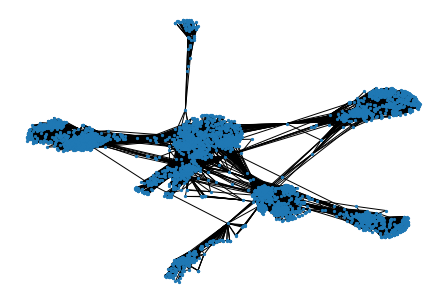

In [15]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)
nx.draw(G, node_size=5)
plt.show()

Tightly clustered social groups are clearly visible within the network. Lets extract these groups using Markov clustering. 

**Listing 23. 15. Finding social groups using Markov clustering**

In [16]:
import markov_clustering as mc
matrix = nx.to_scipy_sparse_matrix(G)
result = mc.run_mcl(matrix)
clusters = mc.get_clusters(result) 
num_clusters = len(clusters)
print(f"{num_clusters} clusters were found in the social graph.")

10 clusters were found in the social graph.


Ten clusters were found in the social graph. Lets visualize these clusters by coloring each node based on cluster id. To start, we'll need to iterate over `clusters` and assign a `cluster_id` attribute to every node.

**Listing 23. 16. Assigning cluster attributes to nodes**

In [17]:
for cluster_id, node_indices in enumerate(clusters):
    for i in node_indices:
        node = nodes[i]
        G.nodes[node]['cluster_id'] = cluster_id

Next, we'll color the nodes based on their attribute assignment.

**Listing 23. 17. Coloring the nodes by cluster assignment**

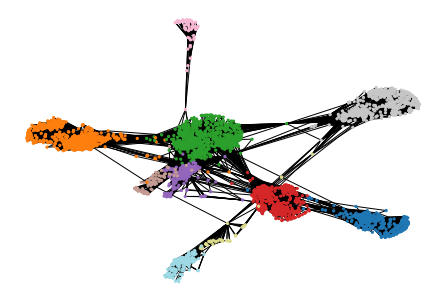

In [18]:
np.random.seed(0)
colors = [G.nodes[n]['cluster_id'] for n in G.nodes]
nx.draw(G, node_size=5, node_color=colors, cmap=plt.cm.tab20)
plt.show()

The cluster colors clearly correspond to tight social groups. Our clustering thus has been effective. Hence, the assigned `cluster_id` attributes should prove useful during the model-building process. In this same manner, it might be useful to store all five profile features as attributes within the student nodes. 

**Listing 23. 18. Assigning profile attributes to nodes**

In [19]:
attribute_names = df_profile.columns
for attributes in df_profile.values:
    profile_id = attributes[0]
    for name, att in zip(attribute_names[1:], attributes[1:]):
        G.nodes[profile_id][name] = att
        
first_node = nodes[0]
print(f"Attributes of node {first_node}:")
print(G.nodes[first_node])

Attributes of node 2899:
{'cluster_id': 0, 'Sex': 0, 'Relationship_Status': 0, 'Dorm': 5, 'Major': 13, 'Year': 2}


We have finished exploring our input data. Now, we'll proceed to train a model that predicts user behavior. We'll start by constructing simple model that only utilizes network features.

## 23. 2 Training a Predictive Model Using Network Features

Our goal is to train a supervised ML model on our dataset, in order to predict user behavior. Currently, all possible classes of behavior are stored within  the _Behavior_ columns of `df_obs`. We'll assign our training class-label array to equal the `df_obs.Behavior` column.

**Listing 23. 19. Assigning the class-label array `y`**

In [20]:
y = df_obs.Behavior.values
print(y)

[0 0 0 ... 1 1 1]


Now that we have class-labels, we'll need to create a feature-matrix `X`. Let's create an initial version of `X`, and populate it with some very basic features. The simplest question we can ask about a person within a social network is this; how many friends does the person have? Of course, that value equals edge-count associated with the person's node within the social graph. Lets make the edge-count our first feature in the feature-matrix. We'll iterate over all the rows in `df_obs` and assign an edge-count to each profile that's referenced within each row. 

**Listing 23. 20. Creating a feature-matrix from edge counts**

In [21]:
cols = ['Profile_ID', 'Friend', 'FoF']
features = {f'{col}_Edge_Count': [] for col in cols}
for node_ids in df_obs[cols].values:
    for node, feature_name in zip(node_ids, features.keys()):
        degree = G.degree(node)
        features[feature_name].append(degree)

df_features = pd.DataFrame(features)
X = df_features.values

Lets quickly check the quality of the signal in the training data by training and testing a simple model. We have multiple possible models to choose from. One sensible choice is a decision tree classifier. Decision trees can handle non-linear decision boundaries and are easily interpretable. 

**Listing 23. 21. Training and evaluating a Decision tree classifier**

In [22]:
np.random.seed(0)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

def evaluate(X, y, model_type=DecisionTreeClassifier, **kwargs):
    np.random.seed(0)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    clf = model_type(**kwargs)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    f_measure = f1_score(pred, y_test, average='macro')
    return f_measure, clf

f_measure, clf = evaluate(X, y)
print(f"The f-measure is {f_measure:0.2f}")

The f-measure is 0.37


Our f-measure is terrible! Clearly, friend-count by itself is not a sufficient signal for predicting user-behavior. Perhaps adding PageRank values to our training set will yield improved results? 

**Listing 23. 22. Adding PageRank features**

In [23]:
np.random.seed(0)
node_to_pagerank = nx.pagerank(G)
features = {f'{col}_PageRank': [] for col in cols}
for node_ids in df_obs[cols].values:
    for node, feature_name in zip(node_ids, features.keys()):
        pagerank = node_to_pagerank[node]
        features[feature_name].append(pagerank)

def update_features(new_features):
    for feature_name, values in new_features.items():
        df_features[feature_name] = values
    return df_features.values

X = update_features(features)
f_measure, clf = evaluate(X, y)

print(f"The f-measure is {f_measure:0.2f}")

The f-measure is 0.38


The f-measure remains approximately the same. Basic centrality measures are insufficient. We need to expand `X` to include the social groups uncovered by Markov Clustering.  One approach is just consider the following binary question; are two people in the same social group? Yes or no? If they are, then perhaps they are more likely to eventually become friends on FriendHook. We can make this binary comparison between each pair of profile-ids within a single row of observations. 

**Listing 23. 23. Adding social group features**

In [24]:
np.random.seed(0)
features = {f'Shared_Cluster_{e}': []
            for e in ['id_f', 'id_fof', 'f_fof']}

i = 0
for node_ids in df_obs[cols].values:
    c_id, c_f, c_fof = [G.nodes[n]['cluster_id'] 
                        for n in node_ids]
    features['Shared_Cluster_id_f'].append(int(c_id == c_f))
    features['Shared_Cluster_id_fof'].append(int(c_id == c_fof))
    features['Shared_Cluster_f_fof'].append(int(c_f == c_fof))
    
X = update_features(features)
f_measure, clf = evaluate(X, y)
print(f"The f-measure is {f_measure:0.2f}") 

The f-measure is 0.43


Our f-measure has noticeably improved, from 0.38 to 0.43. Perfomance is still poor. Nonetheless, the social group inclusion has led a slight enhacement of our model. How important are the new social group features relative the model's current perfomance? We can find check, using the `feature_importance_` attribute of our trained classifier.

**Listing 23. 24. Ranking features by their importance score**

In [25]:
def view_top_features(clf, feature_names):
    for i in np.argsort(clf.feature_importances_)[::-1]:
        feature_name = feature_names[i]
        importance = clf.feature_importances_[i]
        if not round(importance, 2):
            break
            
        print(f"{feature_name}: {importance:0.2f}")
feature_names = df_features.columns
view_top_features(clf, feature_names)

Shared_Cluster_id_fof: 0.18
FoF_PageRank: 0.17
Profile_ID_PageRank: 0.17
Friend_PageRank: 0.15
FoF_Edge_Count: 0.12
Profile_ID_Edge_Count: 0.11
Friend_Edge_Count: 0.10


Social graph centrality plays some role in friendship determination. Of course, our model's performance is still poor, so we should be cautious with our inferences on how the features drive predictions.  What other graph-based features could we utilize? Perhaps the network cluster size can impact the predictions? We can find out. However, we should be cautious in our efforts to keep our model generalizable. Cluster size can inexplicably take the place of cluster-id, making the model very specific to the university. 

**Listing 23. 25. Adding cluster-size features**

In [26]:
np.random.seed(0)
cluster_sizes = [len(cluster) for cluster in clusters]
features = {f'{col}_Cluster_Size': [] for col in cols}
for node_ids in df_obs[cols].values:
    for node, feature_name in zip(node_ids, features.keys()):
        c_id = G.nodes[node]['cluster_id']
        features[feature_name].append(cluster_sizes[c_id])
    
X = update_features(features)
f_measure, clf = evaluate(X, y)
print(f"The f-measure is {f_measure:0.2f}")

The f-measure is 0.43


The cluster did not improve the model. As a precaution, lets delete it from our feature set.

**Listing 23. 26. Deleting cluster-size features**

In [27]:
import re
def delete_features(df_features, regex=r'Cluster_Size'):
    
    df_features.drop(columns=[name for name in df_features.columns
                               if re.search(regex, name)], inplace=True)
    return df_features.values

X = delete_features(df_features)

The f-measure remains at 0.43. Perhaps we should try thinking outside the box. In what ways can social connections drive real world-behavior? Consider the following scenario. Suppose we analyze a student named Alex, whose node id in network `G` is `n`. Alex has 50 FriendHook friends. These are accessible through `G[n]`. We randomly sample two of the friends in `G[n]`. Their node ids are `a` and `b`. We then check if `a` and `b` are friends. They are! It seems that `a` is in `list(G[n])`. We then repeat this 100 times. In 95% percent of sampled instances, `a` is friend of `b`. Basically, there's a 95% likelihood that any pair of Alex's friends are also friends with each other. We'll refer to this probability as the **friend-sharing likelihood**.  Lets try incorporating this likelihood into our features. We'll start by computing the likehood for every node in `G`. 

**Listing 23. 27. Computing friend-sharing likelihoods**

In [28]:
friend_sharing_likelihood = {}
for node in nodes:
    neighbors = list(G[node])
    friendship_count = 0
    total_possible = 0
    for i, node1 in enumerate(neighbors[:-1]):
        for node2 in neighbors[i + 1:]:
            if node1 in G[node2]:
                friendship_count += 1
                
            total_possible += 1
    
    prob = friendship_count / total_possible if total_possible else 0
    friend_sharing_likelihood[node] = prob

Next, we'll generate a friend-sharing likelihood feature for each of our three profile ids. After adding the features, we'll re-valuate the trained model's performance.

**Listing 23. 28. Adding friend-sharing likelihood features**

In [29]:
np.random.seed(0)
features = {f'{col}_Friend_Sharing_Likelihood': [] for col in cols}
for node_ids in df_obs[cols].values:
    for node, feature_name in zip(node_ids, features.keys()):
        sharing_likelihood = friend_sharing_likelihood[node]
        features[feature_name].append(sharing_likelihood)

X = update_features(features)
f_measure, clf = evaluate(X, y)
print(f"The f-measure is {f_measure:0.2f}")

The f-measure is 0.49


Performance has increased from 0.43 to 0.49! It's still not great, but its progressively getting better. How does the friend-sharing likelihood compare to other features in the model? Lets find out!

**Listing 23. 29. Ranking features by their importance score**

In [30]:
feature_names = df_features.columns
view_top_features(clf, feature_names)

Shared_Cluster_id_fof: 0.18
Friend_Friend_Sharing_Likelihood: 0.13
FoF_PageRank: 0.11
Profile_ID_PageRank: 0.11
Profile_ID_Friend_Sharing_Likelihood: 0.10
FoF_Friend_Sharing_Likelihood: 0.10
FoF_Edge_Count: 0.08
Friend_PageRank: 0.07
Profile_ID_Edge_Count: 0.07
Friend_Edge_Count: 0.06


One of our new features ranks quite highly.Nonetheless, the model is incomplete. An f-measure of 0.49 is not acceptable. We need to incorporate features from the profiles stored within `df_profiles`.

## 23. 3 Adding Profile Features to the Model


Our aim is to incorporate the profile attributes of _Sex_, _Relationship_Status_, _Major_, _Dorm_ and _Year_ into our feature matrix. Based on our experience with the network data, there are three ways in which we can do this:
1. Exact Value Extraction.
    * We can store the exact value of the profile feature associated with each of the three profile-id columns in `df_obs`.
   
2. Equivalence Comparison
    * Given a profile attribute, we can carry-out a pairwise comparison of the attribute across all three profile-id columns in `df_obs`. For each comparison we would return a boolean feature demarcating whether the attribute is equal within the two columns.
   
3. Size:
    * Given a profile attribute, we can return the number of profiles that share that attribute.
  
    
Let's apply Exact Value Extraction to _Sex_, _Relationship_Status_ and _Year_. 

**Listing 23. 30. Adding exact-value profile features**

In [31]:
attributes = ['Sex', 'Relationship_Status', 'Year']
for attribute in attributes:
    features = {f'{col}_{attribute}_Value': [] for col in cols}
    for node_ids in df_obs[cols].values:
        for node, feature_name in zip(node_ids, features.keys()):
            att_value = G.nodes[node][attribute]
            features[feature_name].append(att_value)
    
    X = update_features(features)
    
f_measure, clf = evaluate(X, y)
print(f"The f-measure is {f_measure:0.2f}") 

The f-measure is 0.74


Wow! The f-measure dramatically increased from 0.49 to 0.74! The profile features have provided a very valuable signal, but we can still do better. We need to incorporate information from the _Major_ and _Dorm_ attributes. Equivalence Comparison is an excellent way to do this.

**Listing 23. 31. Adding equivalence-comparison profile features**

In [32]:
attributes = ['Major', 'Dorm']
for attribute in attributes:
    features = {f'Shared_{attribute}_{e}': []
            for e in ['id_f', 'id_fof', 'f_fof']}
    for node_ids in df_obs[cols].values:
        att_id, att_f, att_fof = [G.nodes[n][attribute] 
                                  for n in node_ids]
        features[f'Shared_{attribute}_id_f'].append(int(att_id == att_f))
        features[f'Shared_{attribute}_id_fof'].append(int(att_id == att_fof))
        features[f'Shared_{attribute}_f_fof'].append(int(att_f == att_fof))
        
    X = update_features(features)
        
f_measure, clf = evaluate(X, y)
print(f"The f-measure is {f_measure:0.2f}") 

The f-measure is 0.82


Incorporating the _Major_ and _Dorm_ attributes has improved model performance. Now lets consider adding _Major_ and _Dorm Size_ into the mix. We can count the number of students associated with each major / dorm, and include this count as one of our features. However, we need to be careful. As we previously discussed, our trained model can cheat by utilizing size as a substitute for a category id. 

**Listing 23. 32. Adding size-related profile features**

In [33]:
from collections import Counter

for attribute in ['Major', 'Dorm']:
    counter = Counter(df_profile[attribute].values)
    att_to_size = {k: v 
                      for k, v in counter.items()}
    features = {f'{col}_{attribute}_Size': [] for col in cols}
    for node_ids in df_obs[cols].values:
        for node, feature_name in zip(node_ids, features.keys()):
            size = att_to_size[G.nodes[node][attribute]]
            features[feature_name].append(size)
    
    
    X = update_features(features)
    
f_measure, clf = evaluate(X, y)
print(f"The f-measure is {f_measure:0.2f}") 

The f-measure is 0.85


Performance has increased from 0.82 to 0.85. The introduction of size has impacted our model. Lets dive deeper into that impact. We'll start by printing out the feature importance scores.

**Listing 23. 33. Ranking features by their importance score**

In [34]:
feature_names = df_features.columns.values
view_top_features(clf, feature_names)

FoF_Dorm_Size: 0.25
Shared_Cluster_id_fof: 0.16
Shared_Dorm_id_fof: 0.05
FoF_PageRank: 0.04
Profile_ID_Major_Size: 0.04
FoF_Major_Size: 0.04
FoF_Edge_Count: 0.04
Profile_ID_PageRank: 0.03
Profile_ID_Friend_Sharing_Likelihood: 0.03
Friend_Friend_Sharing_Likelihood: 0.03
Friend_Edge_Count: 0.03
Shared_Major_id_fof: 0.03
FoF_Friend_Sharing_Likelihood: 0.02
Friend_PageRank: 0.02
Profile_ID_Dorm_Size: 0.02
Profile_ID_Edge_Count: 0.02
Profile_ID_Sex_Value: 0.02
Friend_Major_Size: 0.02
Profile_ID_Relationship_Status_Value: 0.02
FoF_Sex_Value: 0.01
Friend_Dorm_Size: 0.01
Profile_ID_Year_Value: 0.01
Friend_Sex_Value: 0.01
Shared_Major_id_f: 0.01
Friend_Relationship_Status_Value: 0.01
Friend_Year_Value: 0.01


The feature importance scores are dominated by two features; _FoF_Dorm_Size_ and _Shared_Cluster_id_fof_. The presence of _FoF_Dorm_Size_ is a bit concerning. As we've discussed, a single dorm dominates over 50% of the network data. Is our model simply memorizing that dorm based on its size? We can find out by actually visualizing a trained decision tree. 

**Listing 23. 34. Displaying the top branches of the tree**

In [35]:
from sklearn import tree

clf_depth2 = DecisionTreeClassifier(max_depth=2)
clf_depth2.fit(X, y)
text_tree = tree.export_text(clf_depth2, feature_names=list(feature_names))
print(text_tree)

|--- FoF_Dorm_Size <= 278.50
|   |--- Shared_Cluster_id_fof <= 0.50
|   |   |--- class: 0
|   |--- Shared_Cluster_id_fof >  0.50
|   |   |--- class: 0
|--- FoF_Dorm_Size >  278.50
|   |--- Shared_Cluster_id_fof <= 0.50
|   |   |--- class: 0
|   |--- Shared_Cluster_id_fof >  0.50
|   |   |--- class: 1



According to the the tree, the most important signal is whether _FoF_Dorm_Size_ is less than 279. This begs the question, how many dorms contain at-least 279 students? 

**Listing 23. 35. Checking dorms with at-least 279 students**

In [36]:
counter = Counter(df_profile.Dorm.values)
for dorm, count in counter.items():
    if count < 279:
        continue
        
    print(f"Dorm {dorm} holds {count} students.")

Dorm 12 holds 2739 students.
Dorm 1 holds 413 students.


Just two of the 15 dorms contain more than 279 FriendHook-registered students. Essentially, our model relies on the two most-populous dorms to make its decisions. This might not generalize to other college campuses. For instance, consider a campus whose dormitories are smaller, and hold 200 students at the most. The model will completely fail to predict user-behavior in this instance. 

Perhaps we could try deleting the size-related features while also adjusting our choice of classifier. There is a slight chance that we'll achieve comparable performance without relying on dorm size. This is unlikely but is still worth trying. 

**Listing 23. 36. Deleting all size-related features**

In [37]:
X_with_sizes = X.copy()
X = delete_features(df_features, regex=r'_Size')

## 23. 4 Optimizing Performance Across a Steady Set of Features

Will switching the model-type from a Decision tree to a Forest improve performance outcome? Lets find out.

**Listing 23. 37. Training and evaluating a Random Forest classifier**

In [38]:
np.random.seed(0)
from sklearn.ensemble import RandomForestClassifier
f_measure, clf = evaluate(X, y, model_type=RandomForestClassifier)
print(f"The f-measure is {f_measure:0.2f}") 

The f-measure is 0.75



Switching the type of model has not helped. Perhaps instead we can boost performance by optimizing on the hyperparameters? Within this book, we've focused on single Decision tree hyperparameter; max depth. Will limiting the depth improve our predictions? Lets quickly check using a simple grid search. 

**Listing 23. 38. Optimizing max depth using grid search**

In [39]:
from sklearn.model_selection import GridSearchCV
np.random.seed(0)

hyperparams = {'max_depth': list(range(1, 100)) + [None]}
clf_grid = GridSearchCV(DecisionTreeClassifier(), hyperparams, 
                        scoring='f1_macro', cv=2)
clf_grid.fit(X, y)
best_f = clf_grid.best_score_
best_depth = clf_grid.best_params_['max_depth']
print(f"A maximized f-measure of {best_f:.2f} is achieved when "
      f"max_depth equals {best_depth}") 

A maximized f-measure of 0.84 is achieved when max_depth equals 5


Setting `max_depth` to 5 improves the f-measure from from 0.82 to 0.84. This level of performance is comperable with our Dorm-size dependent model. Of course, we cannot make a fair comparison without first running a grid search on the size-inclusive `X_with_size` feature-matrix. Will optimizing on `X_with_size` yield an even better classifier? Lets find out.

**Listing 23. 39. Applying grid search to size-dependent training data**

In [40]:
np.random.seed(0)
clf_grid.fit(X_with_sizes, y)
best_f = clf_grid.best_score_
best_depth = clf_grid.best_params_['max_depth']
print(f"A maximized f-measure of {best_f:.2f} is achieved when "
      f"max_depth equals {best_depth}") 

A maximized f-measure of 0.85 is achieved when max_depth equals 6


The grid search did not improve performance on `X_with_size`. Thus, we can conclude that with the right choice of max-depth, both the size-dependent and independent models perform with approximately equal quality. Consequently, we can train a generalizable, size-independent model without sacrificing perfomance. 

**Listing 23. 40. Training a Decision tree with `max_depth` set to 5**

In [41]:
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=5)

## 23. 6 Interpreting the Trained Model

Lets print our model's feature importance scores.

**Listing 23. 41. Ranking features by their importance score**

In [42]:
feature_names = df_features.columns
view_top_features(clf, feature_names)

Shared_Dorm_id_fof: 0.42
Shared_Cluster_id_fof: 0.29
Shared_Major_id_fof: 0.10
Shared_Dorm_f_fof: 0.06
Profile_ID_Relationship_Status_Value: 0.04
Profile_ID_Sex_Value: 0.04
Friend_Edge_Count: 0.02
Friend_PageRank: 0.01
Shared_Dorm_id_f: 0.01


Only nine important features remain. Only three features have an importance score that's at or above 0.10. These are `Shared_Dorm_id_fof`, `Shared_Cluster_id_fof`, and `Shared_Major_id_fof`. Thus, the model is primarily driven by the following three questions:

1. Do the the user and the friend-of-friend share a dormitory? Yes or no?
2. Do the the user and the friend-of-friend share a social group? Yes or no?
3. Do the the user and the friend-of-friend share a major? Yes or no?

Intuitively, if the answers to all three questions are _Yes_, then the user and the friend-of-a-friend are more likely to connect on FriendHook. Lets test this intutition, by displaying the tree. 

**Listing 23. 42. Displaying the top branches of the tree**

In [43]:
clf_depth3 = DecisionTreeClassifier(max_depth=3)
clf_depth3.fit(X, y)
text_tree = tree.export_text(clf_depth3, 
                             feature_names=list(feature_names))
print(text_tree)

|--- Shared_Dorm_id_fof <= 0.50
|   |--- Shared_Cluster_id_fof <= 0.50
|   |   |--- Shared_Major_id_fof <= 0.50
|   |   |   |--- class: 0
|   |   |--- Shared_Major_id_fof >  0.50
|   |   |   |--- class: 0
|   |--- Shared_Cluster_id_fof >  0.50
|   |   |--- Shared_Major_id_fof <= 0.50
|   |   |   |--- class: 0
|   |   |--- Shared_Major_id_fof >  0.50
|   |   |   |--- class: 1
|--- Shared_Dorm_id_fof >  0.50
|   |--- Shared_Cluster_id_fof <= 0.50
|   |   |--- Profile_ID_Sex_Value <= 0.50
|   |   |   |--- class: 0
|   |   |--- Profile_ID_Sex_Value >  0.50
|   |   |   |--- class: 2
|   |--- Shared_Cluster_id_fof >  0.50
|   |   |--- Shared_Dorm_f_fof <= 0.50
|   |   |   |--- class: 1
|   |   |--- Shared_Dorm_f_fof >  0.50
|   |   |   |--- class: 1




The model's logic is very straightforward. Users who share social groups and living spaces or study-schedules are more likely to connect. There's nothing suprising about that. What is suprising is how the _Sex_ feature drives _Class 2_ label prediction. According to our tree, rejection is more likeley when:

1. The users share a dorm but are not in the same social group.
2. The request sender is of a certain specific sex.

Of course, we know that _Class 2_ labels are fairly sparse within our data. Perhaps the model's predictions are caused by random noise arising from the sparse sampling? Lets quickly check how well we predict rejection. 

**Listing 23. 43. Evaluating a rejection classifier**

In [44]:
y_reject = y *(y == 2)
f_measure, clf_reject = evaluate(X, y_reject, max_depth=5)
print(f"The f-measure is {f_measure:0.2f}") 

The f-measure is 0.97


Wow, the f-measure is actually very high! We can predict rejection very well, despite the sparsity of data. What features drive rejection? Lets check by printing the new feature importance scores.

**Listing 23. 44. Ranking features by their importance score**

In [45]:
view_top_features(clf_reject, feature_names)

Profile_ID_Sex_Value: 0.40
Profile_ID_Relationship_Status_Value: 0.24
Shared_Major_id_fof: 0.21
Shared_Cluster_id_fof: 0.10
Shared_Dorm_id_fof: 0.05


Interesting! Rejection is primarily driven by the user's _Sex_ and _Relationship_Status_ attributes. Lets visualize the trained tree to learn more.

**Listing 23. 45. Displaying the rejection-predicting tree**

In [46]:
text_tree = tree.export_text(clf_reject, 
                             feature_names=list(feature_names))
print(text_tree)

|--- Shared_Cluster_id_fof <= 0.50
|   |--- Shared_Major_id_fof <= 0.50
|   |   |--- Shared_Dorm_id_fof <= 0.50
|   |   |   |--- class: 0
|   |   |--- Shared_Dorm_id_fof >  0.50
|   |   |   |--- Profile_ID_Relationship_Status_Value <= 2.50
|   |   |   |   |--- class: 0
|   |   |   |--- Profile_ID_Relationship_Status_Value >  2.50
|   |   |   |   |--- Profile_ID_Sex_Value <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Profile_ID_Sex_Value >  0.50
|   |   |   |   |   |--- class: 2
|   |--- Shared_Major_id_fof >  0.50
|   |   |--- Profile_ID_Sex_Value <= 0.50
|   |   |   |--- class: 0
|   |   |--- Profile_ID_Sex_Value >  0.50
|   |   |   |--- Profile_ID_Relationship_Status_Value <= 2.50
|   |   |   |   |--- class: 0
|   |   |   |--- Profile_ID_Relationship_Status_Value >  2.50
|   |   |   |   |--- class: 2
|--- Shared_Cluster_id_fof >  0.50
|   |--- class: 0



According to the tree, individuals with _Sex Category 1_ and _Relationship Status Category 3_ are sending friend-requests to people outside their social group. These friend requests are likely to get rejected. Of course, we don't know the identify of the categories that lead to rejection. However, as scientists, we still speculate. Given what we know about human nature, it wouldn't be suprising this behavior is driven by single men. Perhaps they are trying to connect with women outside their social circle, in order to get a date? If, so then the request will probably be rejected. Again, all this is speculation. However, this hypothesis is worth discussing with the product managers at FriendHook. If our hypothesis is correct, then certain changes should be introduced to the product. More steps could be taken to limit unwanted dating requests. Alternatively, new product changes could be added that make easier for single people to connect.